In [2]:
import torch
import numpy as np

In [2]:
cd '/home/animesh/Desktop/Research Project/MANNSuite/Matrix-NTM'

/home/animesh/Desktop/Research Project/MANNSuite/Matrix-NTM


In [3]:
MNTM = torch.load('/home/animesh/Desktop/Research Project/MANNSuite/Matrix-NTM/SavedModels/MatNTM_Train_MatRepCopy1Cuda/INP6_6_HID30_30_MD120_6_6_Adam4CE_RepCopy100000/MNTM.pth')

In [3]:
import matplotlib.pyplot as plt

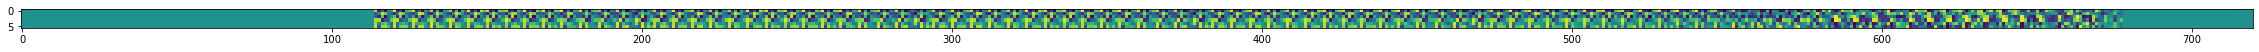

In [5]:
batch_num = 0
plt.figure(figsize=(40,24))
plt.imshow( torch.cat([MNTM.MemoryUnit.Memory.detach().cpu()[batch_num][i] for i  in range(120)], dim = 1) )

In [8]:



def RepeatCopy(batch_size = 32, inp_size = [6,5], seq_length = 4, num_repeats = 2, max_repeats = 30, device=None):
    
    #assert (inp_size[0] - 1)*inp_size[1] >= num_repeats, 'num_repeats too high.'
    
    sequence = torch.rand([batch_size, inp_size[0], inp_size[1]*seq_length])
    sequence[:,inp_size[1]-1:,:] = 0.0
    
    sequence[sequence>0.5] = 1.0
    sequence[sequence<=0.5] = 0.0
    
#     eof_lim = torch.zeros([batch_size,*inp_size])
#     eof_lim[:,-1,0] = 1.0
#     eof_lim[:,-1,-1] = 1.0
    
#     repeats = torch.zeros([batch_size, (inp_size[0]-1)*inp_size[1]])
#     repeats[:,(inp_size[0]-1)*inp_size[1] - num_repeats:] = 1.0
#     repeats = repeats.reshape([batch_size, inp_size[0]-1, inp_size[1]])
#     repeats = torch.cat([repeats, torch.zeros([batch_size,1, inp_size[1]])], dim = 1)
    
    #Assuming repeats \sim Unif(1,max_repeats)
    repeats = torch.zeros([batch_size, *inp_size])
    mean = (max_repeats - 1)/2
    std = (((max_repeats )**2 - 1)/12 )**0.5
    repeats[:,-1,1:-1] = ( num_repeats - mean ) / std
    
    op_start_delim = torch.zeros([batch_size,*inp_size])
    op_start_delim[:,-1,0] = 1.0
    op_start_delim[:,-1,-1] = 1.0
    
    
    output = sequence.repeat([1,1,num_repeats])
    output = torch.cat([output, op_start_delim], dim=2)
    
    sequence = torch.cat([ op_start_delim, sequence, op_start_delim, repeats], dim = 2)
    
    
    return sequence.to(device), output.to(device)

loss_func = torch.nn.BCELoss()



def Bit_Seq_Error(output , target, batch_size=16):
    bit_output = output.detach().clone()
    bit_output[bit_output >= 0.5] = 1.0
    bit_output[bit_output != 1.0] = 0.0
    bit_error = torch.sum((torch.abs(target - bit_output)) )/batch_size
    return bit_error


Epoch:  0
--->Sequence length : 4
--->No. of Repetitions: 9
----->Loss: 0.13596513867378235
----->Bit Sequence Error : 74.3125


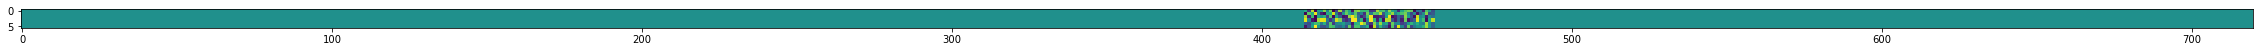

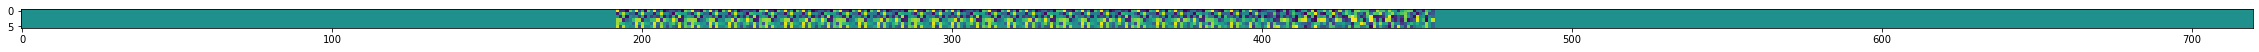

In [15]:
i = 0

seq_length = torch.randint(low=1, high=11, size=[])
num_repeats = torch.randint(low=1, high=11, size=[])

inp, out = RepeatCopy(batch_size=16, inp_size=[6,5], seq_length=seq_length, num_repeats=num_repeats, max_repeats = 10, device='cuda:0')
#inp, out = MatrixCopyDataGen(32,[4,5],num_t)

response_sheet = torch.zeros_like(out)

print("Epoch: ",i)
print("--->Sequence length : {}".format(seq_length) )
print("--->No. of Repetitions: {}".format(num_repeats) )

MNTM.HiddenReset()

MNTM.zero_grad()



#Feeding the sequence
#Input sequence is of length inp.shape[2]/6 

num_sequences = int(inp.shape[2]/5)


for t in range(1,num_sequences+1):
    _ = MNTM(inp[:,:,(t-1)*5:t*5])
                       #6 is the inp_size[1]                    
#del inp

#Taking Output from controller now, for backprop
output = []
        #num_repeats + 1 (+1 for eof delimiter)
for t in range(1, (num_repeats*seq_length +1)  +1):
    MNTM_out = MNTM(response_sheet[:,:,(t-1)*5:t*5])
    output.append(MNTM_out)

#del response_sheet

res = torch.cat(output, dim=2)


loss = loss_func(res, out)                               #^ is the batch size.
bit_seq_error = Bit_Seq_Error(output = res, target = out, batch_size= 16)


#writer.add_scalar('MatNTM_Train_MatRepCopy4/INP6_6_HID30_30_MD120_6_6_Adam4CE_RepCopy100000',loss,i)

print("----->Loss: {}".format(float(loss)))
print("----->Bit Sequence Error : {}".format(float(bit_seq_error)))

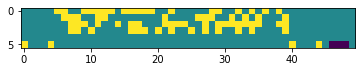

In [10]:
plt.imshow(inp.cpu()[0])

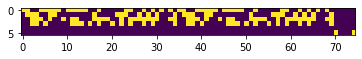

In [11]:
plt.imshow(out.cpu()[0])

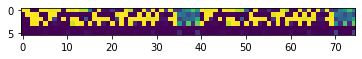

In [13]:
plt.imshow(res.detach().cpu()[0])

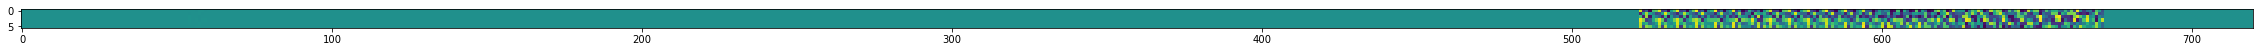

In [14]:
batch_num = 0
plt.figure(figsize=(40,24))
plt.imshow( torch.cat([MNTM.MemoryUnit.Memory.detach().cpu()[batch_num][i] for i  in range(120)], dim = 1) )

In [35]:
def VisualizeWeights(MNTM, batch_num = 0, head_num = 0, seq_length=8, num_repeats=8):
    
    seq_length = seq_length#torch.randint(low=1, high=11, size=[])
    num_repeats = num_repeats#torch.randint(low=1, high=11, size=[])

    inp, out = RepeatCopy(batch_size=16, inp_size=[6,5], seq_length=seq_length, num_repeats=num_repeats, max_repeats = 10, device='cuda:0')
    #inp, out = MatrixCopyDataGen(32,[4,5],num_t)

    response_sheet = torch.zeros_like(out)

    MNTM.HiddenReset()

    MNTM.zero_grad()

    num_sequences = int(inp.shape[2]/5)

    list_read_weights = []
    list_write_weights = []
    memory_list = []
    for t in range(1,num_sequences+1):
        _ = MNTM(inp[:,:,(t-1)*5:t*5])
        list_read_weights.append(MNTM.Controller.HO_Out.ReadWeighings[head_num][batch_num].detach().reshape([120,1]))
        list_write_weights.append(MNTM.Controller.HO_Out.WriteWeighings[head_num][batch_num].detach().reshape([120,1]))
        memory_list.append(torch.cat([MNTM.MemoryUnit.Memory.detach().cpu()[batch_num][i] for i  in range(120)], dim = 1))
    
    output = []

    for t in range(1, (num_repeats*seq_length +1)  +1):
        MNTM_out = MNTM(response_sheet[:,:,(t-1)*5:t*5])
        output.append(MNTM_out)
        list_read_weights.append(MNTM.Controller.HO_Out.ReadWeighings[head_num][batch_num].detach().reshape([120,1]))
        list_write_weights.append(MNTM.Controller.HO_Out.WriteWeighings[head_num][batch_num].detach().reshape([120,1]))
        memory_list.append(torch.cat([MNTM.MemoryUnit.Memory.detach().cpu()[batch_num][i] for i  in range(120)], dim = 1))
        
        
    res = torch.cat(output, dim=2)
    
    
    read_weights = torch.cat(list_read_weights, dim = 1)
    write_weights = torch.cat(list_read_weights, dim = 1)
    memory = torch.cat(memory_list, dim = 0)
    
    
    fig, ax = plt.subplots(1,2, figsize = (20,12))
    ax[0].imshow(read_weights.cpu())
    ax[0].set_title("Read Weights over time")
    ax[1].imshow(write_weights.cpu())
    ax[1].set_title("Write Weights over time")
   
    fig, ax = plt.subplots(2,1, figsize = (20,12))
    ax[0].imshow(memory.cpu())
    ax[0].set_title("Memory Over Time : ")
    ax[1].imshow(res[batch_num].detach().cpu())
    loss = loss_func(res, out)                               #^ is the batch size.
    bit_seq_error = Bit_Seq_Error(output = res, target = out, batch_size= 16)


    #writer.add_scalar('MatNTM_Train_MatRepCopy4/INP6_6_HID30_30_MD120_6_6_Adam4CE_RepCopy100000',loss,i)

    print("----->Loss: {}".format(float(loss)))
    print("----->Bit Sequence Error : {}".format(float(bit_seq_error)))


----->Loss: 0.07026638835668564
----->Bit Sequence Error : 109.3125


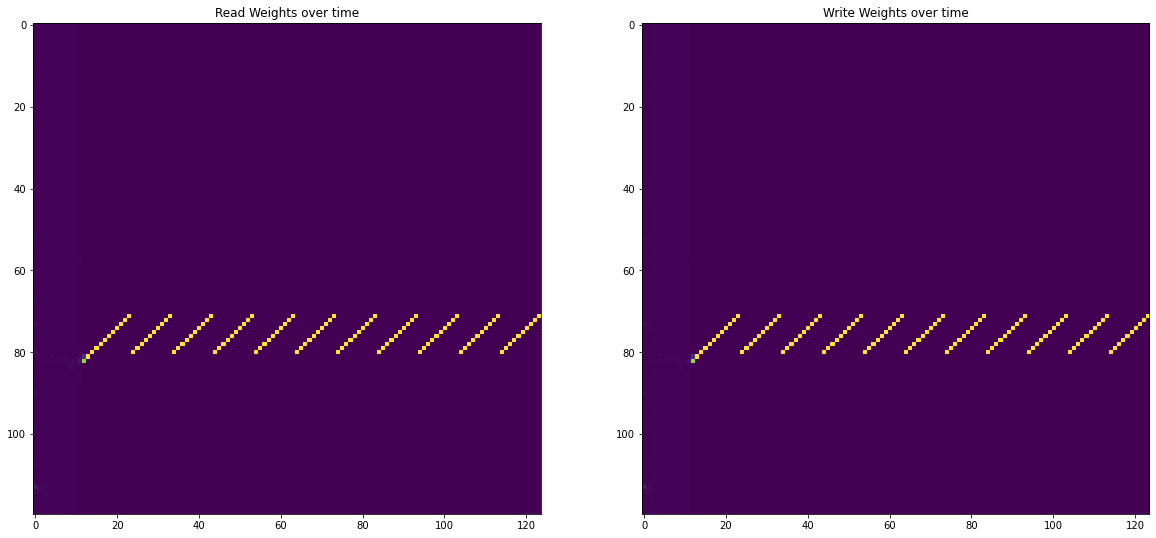

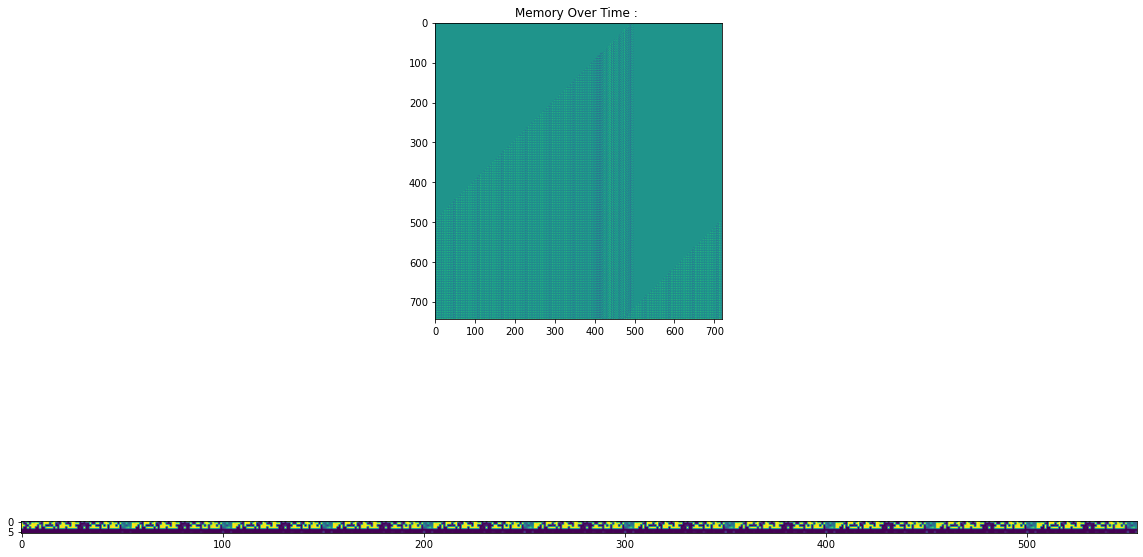

In [38]:
VisualizeWeights(MNTM, seq_length=10, num_repeats=11)

# Delete Below

In [4]:

def OneBatchSequence(seq_size = [4,5], item_size = 2, num_items = 15, query_num = 14, sample_range = [-0.9,0.9]):
    
    #assert num_items > query_num
    
    limiter = torch.zeros([seq_size[0]+1, seq_size[1]])
    limiter[-1,0] = 1.0
    limiter[-1,-1] = 1.0
    
    
    cat_list = []
    for i in range(num_items):
        
        cat_list.append(limiter)
        
        content = torch.rand([seq_size[0]+1, seq_size[1] * item_size])
        content[:-1,:][content[:-1,:] > 0.5] = 1.0
        content[-1,:] = 0.0
        content[content != 1] = 0.0
        cat_list.append(content)
        
    
    delimeter = torch.zeros([seq_size[0]+1, seq_size[1]])
    delimeter[-1,1:-1] = 1.0
    cat_list.append(delimeter)
    
    
    start = seq_size[1]*query_num + (query_num - 1)*(seq_size[1]*(item_size))
    stop = seq_size[1]*query_num + (query_num - 1)*(seq_size[1]*(item_size)) + (seq_size[1]*(item_size)) 
    
    sequence = torch.cat(cat_list, dim = 1)
    

    
    #Colouring sof delimiters
    colours = torch.tensor(np.random.permutation(np.linspace(sample_range[0],sample_range[1],num=num_items+1)))
    #print(colours)
    for i in range(1,1+int(sequence.shape[1]/seq_size[1]),item_size+1):
        #print(i//(item_size+1))
        sequence[-1,i*5 - 5] *= colours[i//(item_size+1)]
        sequence[-1,i*5 - 1] *= colours[i//(item_size+1)]
            
    
    query = sequence[:,start-seq_size[1]:stop - seq_size[1]*(item_size) ]
    expected_result = sequence[:,start  : stop   ] * float(query[-1,0])

    
    
    finalsequence = torch.cat([sequence, query], dim = 1)
    
    
    
    return finalsequence, expected_result




def GenRandBatchSeq(batch_size=32, seq_size = [4,5], item_size = 2, num_items = 15, device = None):
    
    seq_list = []
    res_list = []
    
    
    
    for i in range(batch_size):
        query_num = torch.randint(low=1, high=num_items+1, size=[])
        seq, res = OneBatchSequence(seq_size=seq_size, item_size=item_size, num_items=num_items, query_num=query_num)
        seq_list.append(seq.unsqueeze(0))
        res_list.append(res.unsqueeze(0))
    
    seq_tensor = torch.cat(seq_list, dim=0)
    res_tensor = torch.cat(res_list, dim=0)
    
    return seq_tensor.to(device), res_tensor.to(device)


In [5]:
x,y = GenRandBatchSeq()

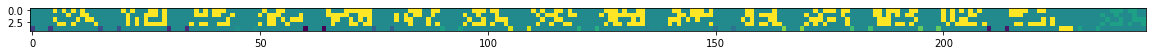

In [6]:
plt.figure(figsize=(20,12))
plt.imshow(torch.cat([x[0],y[0]], dim=1))

In [9]:
x[0].shape

torch.Size([5, 235])

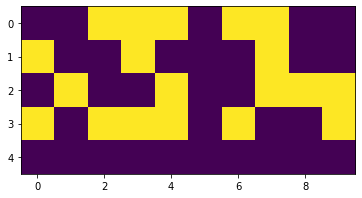

In [10]:
plt.imshow(y[0])